# Stock Market Prediction using ARIMA and Gradient Boosting Models

## Introduction
This notebook demonstrates the process of predicting stock market prices using ARIMA for time-series analysis and Gradient Boosting for machine learning. It includes data preparation, exploratory data analysis, feature engineering, hyperparameter tuning, and model evaluation.

## Step 1: Data Preparation

### Import Libraries


This section imports necessary libraries for data manipulation, time series analysis, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Download Data

Downloads historical stock data for selected equities using the `yfinance` library. The data is then saved to a CSV file.

In [2]:
# Download historical stock data for selected equities
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', group_by='ticker')

# Save data for one stock (example: AAPL)
stock_data = data['AAPL']
stock_data.reset_index(inplace=True)
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
stock_data.set_index('Date', inplace=True)

# Save to CSV file with the ticker name
csv_filename = "Apple_Data.csv"
stock_data.to_csv(csv_filename, index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [3]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778679,24.789802,23.879981,24.320433,212818400
2015-01-05,24.089084,24.169166,23.448429,23.635286,257142000
2015-01-06,23.699796,23.897776,23.274916,23.637510,263188400
2015-01-07,23.846610,24.069060,23.735385,23.968958,160423600
2015-01-08,24.298190,24.947743,24.180291,24.889906,237458000


### Handle Missing Values

This section checks for and fills any missing values in the dataset using forward fill.

In [4]:
stock_data.isnull().sum()

Price
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778681,24.789804,23.879983,24.320435,212818400
2015-01-05,24.089076,24.169158,23.448422,23.635279,257142000
2015-01-06,23.699800,23.897780,23.274920,23.637514,263188400
2015-01-07,23.846616,24.069065,23.735391,23.968964,160423600
2015-01-08,24.298187,24.947740,24.180287,24.889902,237458000


## Step 2: Exploratory Data Analysis (EDA)

### Description

This step involves exploring the dataset using descriptive statistics, data visualization, and correlation analysis to understand the data's characteristics and patterns.

In [7]:
stock_data.describe()

Price,Open,High,Low,Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,94.092764,95.094510,93.162752,94.179886,1.170867e+08
std,65.584580,66.260520,64.976048,65.665067,6.839957e+07
min,20.596719,20.978902,20.475431,20.674532,2.323470e+07
25%,35.363660,35.742676,34.964042,35.343394,7.105610e+07
50%,64.448189,65.164833,63.803500,64.608200,1.003646e+08
75%,150.569900,152.501759,148.774712,150.747746,1.426216e+08
max,257.906429,259.814335,257.347047,258.735504,6.488252e+08


### Info

Displays the data types and non-null counts for each column in the DataFrame.

In [8]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


### Visualize Trends

Plots the closing prices over time to visualize the trend.

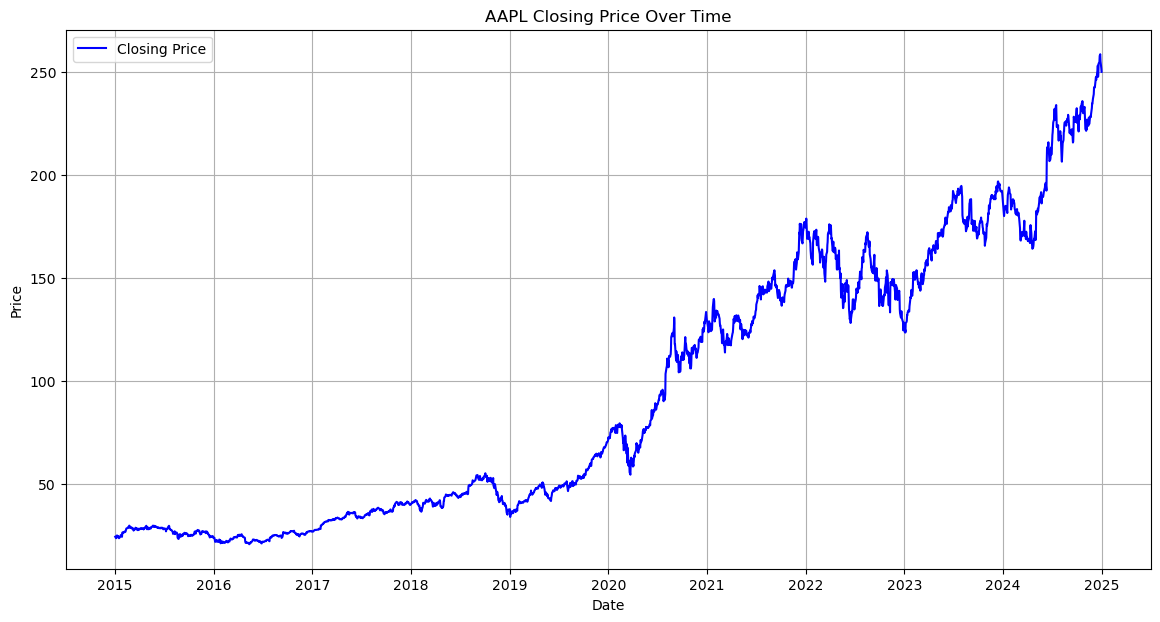

In [9]:
# Plot closing prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Moving Averages

Calculates and visualizes rolling averages to smooth out short-term fluctuations and highlight longer-term trends.

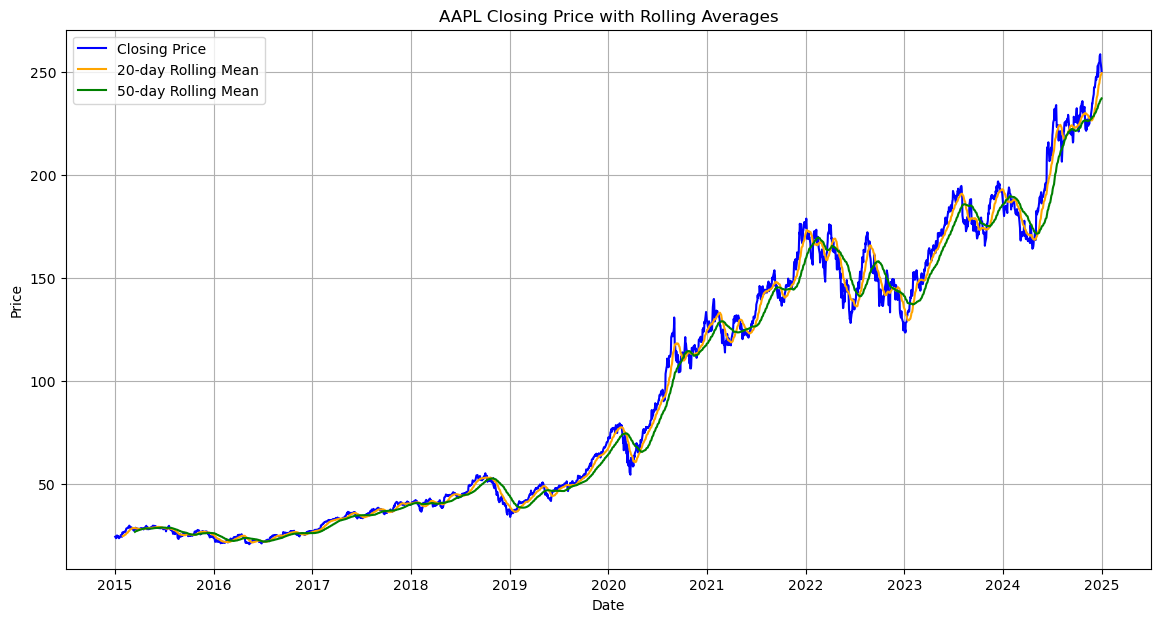

In [10]:
# Add rolling averages for visualization
stock_data['Rolling_Mean_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['Rolling_Mean_50'] = stock_data['Close'].rolling(window=50).mean()

# Plot closing prices and rolling means
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.plot(stock_data['Rolling_Mean_20'], label='20-day Rolling Mean', color='orange')
plt.plot(stock_data['Rolling_Mean_50'], label='50-day Rolling Mean', color='green')
plt.title('AAPL Closing Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Visualize Volume Trends

Plots the trading volume over time to analyze trading activity.

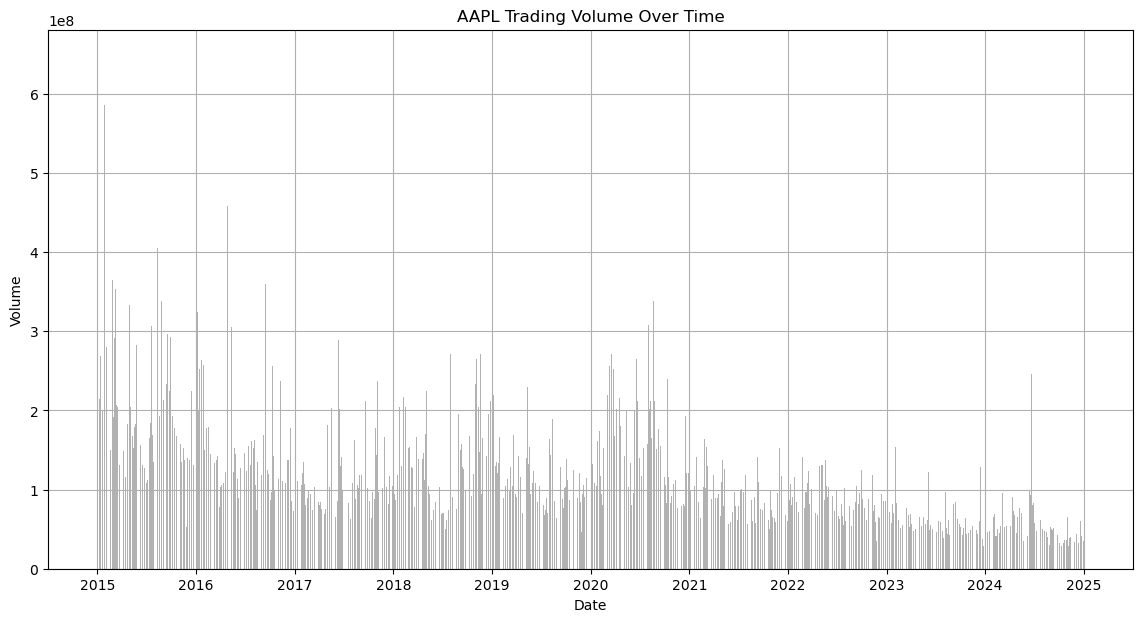

In [11]:
# Plot volume over time to analyze trading activity
plt.figure(figsize=(14, 7))
plt.bar(stock_data.index, stock_data['Volume'], color='gray', alpha=0.6)
plt.title('AAPL Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()


### Correlation Heatmap

Displays the correlation between different features in the dataset.

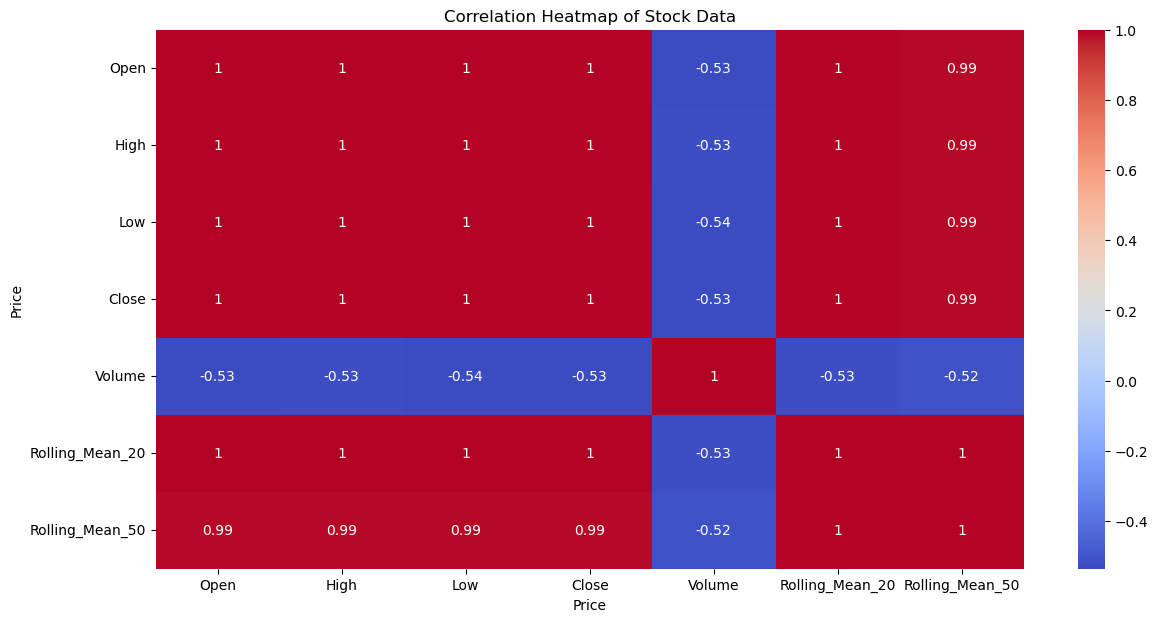

In [12]:
plt.figure(figsize=(14, 7))
sns.heatmap(stock_data.corr(), annot=True, cmap='coolwarm', linecolor='black')
plt.title('Correlation Heatmap of Stock Data')
plt.show()


### Pair Plots

Visualizes the relationships between pairs of variables in the dataset.

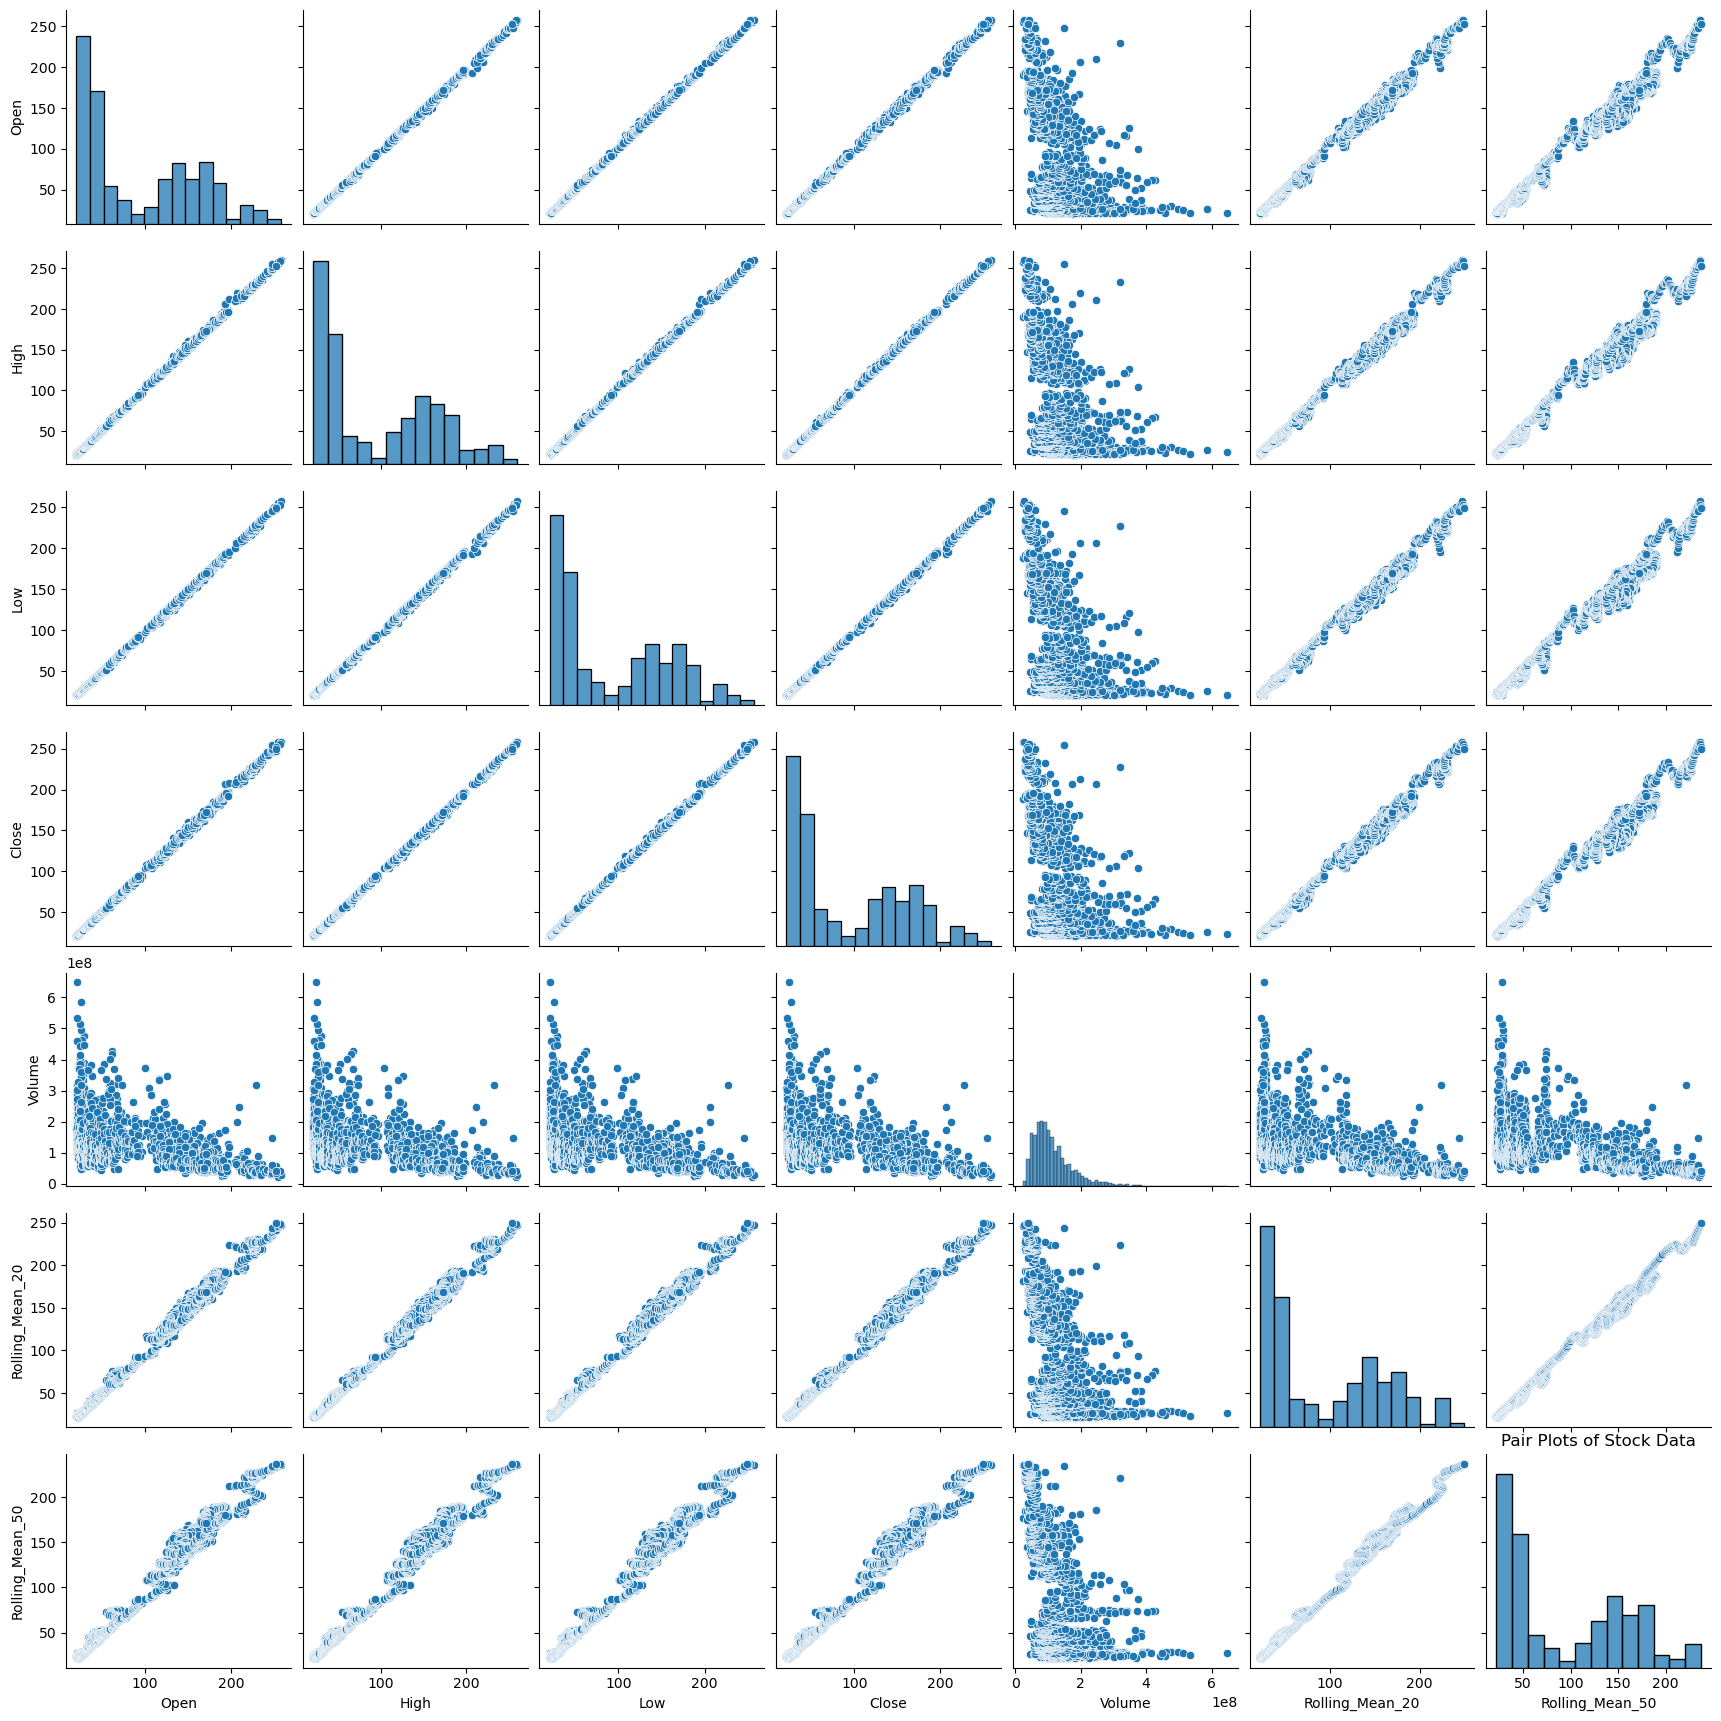

In [13]:
sns.pairplot(stock_data)
plt.title('Pair Plots of Stock Data')
plt.show()

### Distribution of Closing Prices

Plots the distribution of closing prices to understand the frequency of different price ranges.

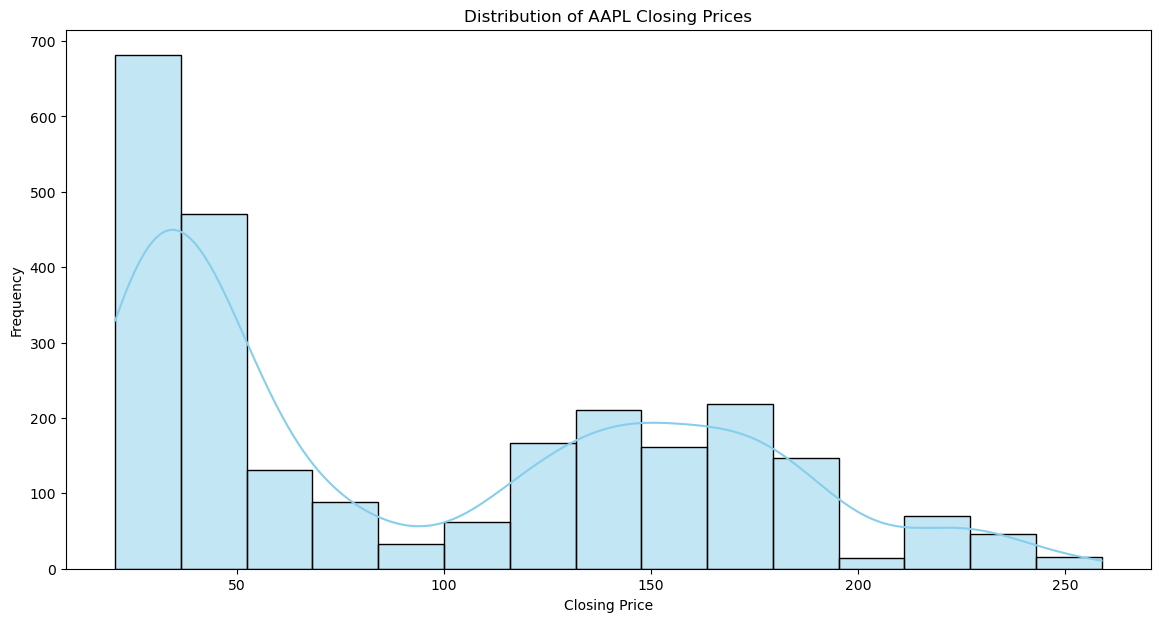

In [14]:
plt.figure(figsize=(14, 7))
sns.histplot(stock_data['Close'], kde=True, color='skyblue')
plt.title('Distribution of AAPL Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

### Box Plot for Volume

Displays a box plot of the trading volume to identify outliers.

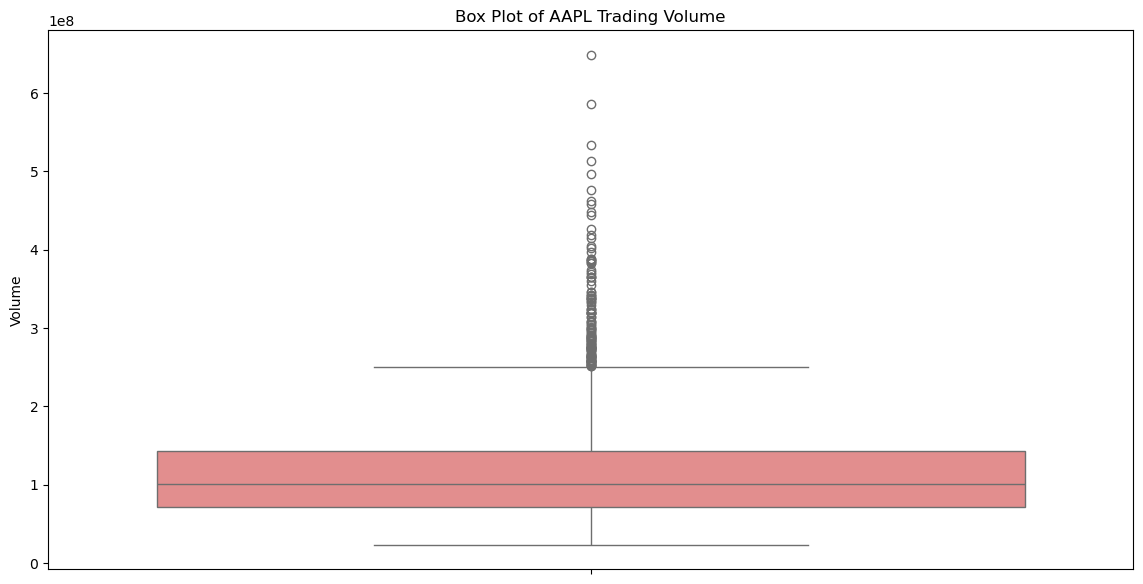

In [15]:
plt.figure(figsize=(14, 7))
sns.boxplot(y=stock_data['Volume'], color='lightcoral')
plt.title('Box Plot of AAPL Trading Volume')
plt.ylabel('Volume')
plt.show()

### Rolling Statistics (Mean and Standard Deviation)

Calculates and visualizes rolling statistics (mean and standard deviation) to assess the stationarity of the time series.

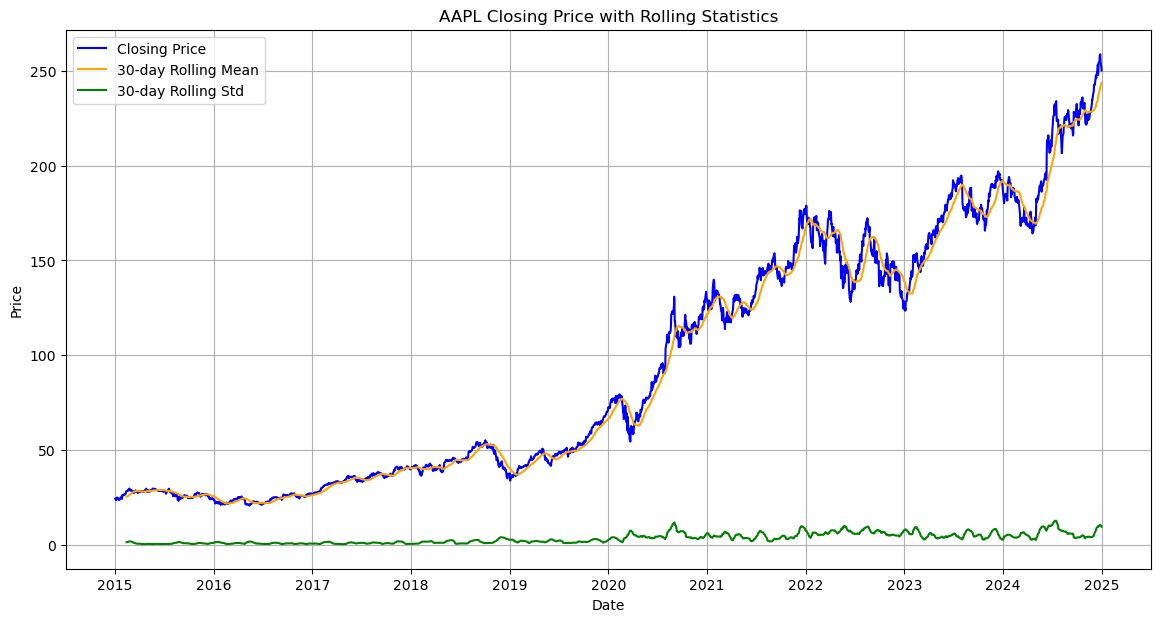

In [16]:
rolling_mean = stock_data['Close'].rolling(window=30).mean()
rolling_std = stock_data['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.plot(rolling_mean, label='30-day Rolling Mean', color='orange')
plt.plot(rolling_std, label='30-day Rolling Std', color='green')
plt.title('AAPL Closing Price with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [4]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778679,24.789802,23.879981,24.320433,212818400
2015-01-05,24.089084,24.169166,23.448429,23.635286,257142000
2015-01-06,23.699796,23.897776,23.274916,23.637510,263188400
2015-01-07,23.846610,24.069060,23.735385,23.968958,160423600
2015-01-08,24.298190,24.947743,24.180291,24.889906,237458000


## Step 3: Feature Engineering

### Create Features

This step creates new features from the existing data to improve the model's predictive power.

In [17]:
# Create lagged features for predictive modeling (previous day's closing price)
stock_data['Lag_1_Close'] = stock_data['Close'].shift(1)

# Rolling mean of closing prices (short-term trends)
stock_data['Rolling_Mean_5'] = stock_data['Close'].rolling(window=5).mean()

# Percentage change in closing price (daily returns)
stock_data['Pct_Change_Close'] = stock_data['Close'].pct_change()

# Drop rows with NA values after feature creation
stock_data.dropna(inplace=True)

In [5]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778679,24.789802,23.879981,24.320433,212818400
2015-01-05,24.089084,24.169166,23.448429,23.635286,257142000
2015-01-06,23.699796,23.897776,23.274916,23.637510,263188400
2015-01-07,23.846610,24.069060,23.735385,23.968958,160423600
2015-01-08,24.298190,24.947743,24.180291,24.889906,237458000


## Step 4: Modeling

### ARIMA Model with Hyperparameter Tuning

This section defines the parameter ranges for ARIMA model tuning and performs a grid search to find the optimal parameters.

In [18]:
# Define parameter ranges for ARIMA model tuning
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq_combinations = list(itertools.product(p, d, q))

best_rmse_arima = float("inf")
best_mae_arima = float("inf")
best_mape_arima = float("inf")
best_pdq = None

# Perform grid search to find optimal ARIMA parameters
for pdq in pdq_combinations:
    try:
        model = ARIMA(stock_data['Close'], order=pdq)
        results = model.fit()
        forecast = results.forecast(steps=10)
        actual = stock_data['Close'].iloc[-10:]  # Last 10 actual values for comparison
        
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        mae = mean_absolute_error(actual, forecast)
        
        if rmse < best_rmse_arima:
            best_rmse_arima = rmse
            best_mae_arima = mae
            best_pdq = pdq
    except:
        continue

print(f"Best Parameters for ARIMA: {best_pdq}")
print(f"Best ARIMA RMSE: {best_rmse_arima}")
print(f"Best ARIMA MAE: {best_mae_arima}")

# Fit final ARIMA model with best parameters
final_arima_model = ARIMA(stock_data['Close'], order=best_pdq).fit()

Best Parameters for ARIMA: (2, 1, 1)
Best ARIMA RMSE: 4.29489347178764
Best ARIMA MAE: 3.5880801001447735


This section specifies fixed parameters for the ARIMA model and fits the model with these parameters.


In [19]:
# Specify fixed parameters for ARIMA model
p = 2  # Autoregressive order
d = 1  # Degree of differencing
q = 1  # Moving average order

# Fit the ARIMA model with specified parameters
final_arima_model = ARIMA(stock_data['Close'], order=(p, d, q)).fit()

# Forecast using the final model
forecast_final = final_arima_model.forecast(steps=10)
actual_final = stock_data['Close'].iloc[-10:]  # Last 10 actual values for comparison

# Calculate metrics
rmse_final = np.sqrt(mean_squared_error(actual_final, forecast_final))
mae_final = mean_absolute_error(actual_final, forecast_final)
mape_final = np.mean(np.abs((actual_final - forecast_final) / actual_final)) * 100
r2_final = r2_score(actual_final, forecast_final)

# Print metrics
print(f"Fixed Parameters for ARIMA: p={p}, d={d}, q={q}")
print(f"ARIMA RMSE: {rmse_final:.4f}")
print(f"ARIMA MAE: {mae_final:.4f}")

Fixed Parameters for ARIMA: p=2, d=1, q=1
ARIMA RMSE: 4.2949
ARIMA MAE: 3.5881


### Gradient Boosting Model with Hyperparameter Tuning

This part defines the features and target variable for the Gradient Boosting model, splits the data into training and testing sets, and performs hyperparameter tuning using RandomizedSearchCV.

In [20]:
# Define features and target variable for Gradient Boosting model
features = ['Lag_1_Close', 'Rolling_Mean_5', 'Pct_Change_Close']
X = stock_data[features]
y = stock_data['Close']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {"learning_rate": [0.1, 0.01],
                "max_depth": [5, 8, 12, 20, 30],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2],
                "subsample": [0.5, 0.8, 1],
                "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

# Initialize Gradient Boosting model and perform grid search tuning
xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_grid,
                                   n_iter=100,
                                   scoring='neg_mean_squared_error',
                                   cv=3)
random_search.fit(X_train, y_train)
# Retrieve best model and evaluate performance on test set
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
# Calculate metrics for the tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test.values, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test.values, y_pred_tuned)
mape_tuned = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100
r2_tuned = r2_score(y_test.values, y_pred_tuned)

# Print results
print("Best Parameters for Gradient Boosting:", random_search.best_params_)
print(f"Tuned Gradient Boosting RMSE: {rmse_tuned:.4f}")
print(f"Tuned Gradient Boosting MAE: {mae_tuned:.4f}")
print(f"Tuned Gradient Boosting MAPE: {mape_tuned:.2f}%")
print(f"Tuned Gradient Boosting R²: {r2_tuned:.4f}")

Best Parameters for Gradient Boosting: {'subsample': 0.8, 'min_child_weight': 3, 'max_depth': 30, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1}
Tuned Gradient Boosting RMSE: 0.9679
Tuned Gradient Boosting MAE: 0.5068
Tuned Gradient Boosting MAPE: 0.55%
Tuned Gradient Boosting R²: 0.9998


This section initializes a Gradient Boosting model with fixed parameters, fits the model on the training data, and predicts on the test data.

In [25]:
# Initialize Gradient Boosting model with fixed parameters
xgb_model = XGBRegressor(
    learning_rate=0.1,  # Fixed learning rate
    max_depth=30,        # Fixed maximum depth of trees
    min_child_weight=3, # Fixed minimum child weight
    gamma=0.1,          # Fixed gamma value
    subsample=0.8,      # Fixed subsample ratio
    colsample_bytree=1,  # Fixed column sampling ratio
    random_state=42     # Random state for reproducibility
)

# Fit the model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Calculate metrics for the tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test.values, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test.values, y_pred_tuned)
mape_tuned = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100
r2_tuned = r2_score(y_test.values, y_pred_tuned)

# Print results
print(f"Gradient Boosting RMSE: {rmse_tuned:.4f}")
print(f"Gradient Boosting MAE: {mae_tuned:.4f}")
print(f"Gradient Boosting MAPE: {mape_tuned:.2f}%")
print(f"Gradient Boosting R²: {r2_tuned:.4f}")

Gradient Boosting RMSE: 0.9679
Gradient Boosting MAE: 0.5068
Gradient Boosting MAPE: 0.55%
Gradient Boosting R²: 0.9998


In [6]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778679,24.789802,23.879981,24.320433,212818400
2015-01-05,24.089084,24.169166,23.448429,23.635286,257142000
2015-01-06,23.699796,23.897776,23.274916,23.637510,263188400
2015-01-07,23.846610,24.069060,23.735385,23.968958,160423600
2015-01-08,24.298190,24.947743,24.180291,24.889906,237458000


## Step 5: Model Evaluation

### Evaluation Metrics

This section evaluates the performance of both the ARIMA and Gradient Boosting models using RMSE, MAE, and MAPE.

In [22]:
# Evaluate ARIMA Model Performance (RMSE, MAE, MAPE)
arima_forecast_test = final_arima_model.forecast(steps=len(y_test))

# RMSE for ARIMA
arima_rmse_test = np.sqrt(mean_squared_error(y_test.values[-len(arima_forecast_test):], arima_forecast_test))

# MAE for ARIMA
arima_mae_test = mean_absolute_error(y_test.values[-len(arima_forecast_test):], arima_forecast_test)

# MAPE for ARIMA
arima_mape_test = np.mean(np.abs((y_test.values[-len(arima_forecast_test):] - arima_forecast_test) / y_test.values[-len(arima_forecast_test):])) * 100

print(f"ARIMA Test RMSE: {arima_rmse_test}")
print(f"ARIMA Test MAE: {arima_mae_test}")
print(f"ARIMA Test MAPE: {arima_mape_test}")

# Evaluate Gradient Boosting Model Performance (RMSE, MAE, MAPE)
# RMSE for Gradient Boosting (already calculated elsewhere as rmse_tuned)
gradient_boosting_rmse_test = rmse_tuned

# MAE for Gradient Boosting
gradient_boosting_mae_test = mean_absolute_error(y_test.values, y_pred_tuned)

# MAPE for Gradient Boosting
gradient_boosting_mape_test = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100

print(f"Gradient Boosting Test RMSE: {gradient_boosting_rmse_test}")
print(f"Gradient Boosting Test MAE: {gradient_boosting_mae_test}")
print(f"Gradient Boosting Test MAPE: {gradient_boosting_mape_test}")

# Compare Results
print("\nComparison of Model Performance:")
print(f"ARIMA RMSE: {arima_rmse_test}, Gradient Boosting RMSE: {gradient_boosting_rmse_test}")
print(f"ARIMA MAE: {arima_mae_test}, Gradient Boosting MAE: {gradient_boosting_mae_test}")
print(f"ARIMA MAPE: {arima_mape_test:.2f}%, Gradient Boosting MAPE: {gradient_boosting_mape_test:.2f}%")

print('\n')
# Decision Making Based on Metrics
if arima_rmse_test < gradient_boosting_rmse_test:
    print("ARIMA performs better in terms of RMSE.")
else:
    print("Gradient Boosting performs better in terms of RMSE.")

if arima_mae_test < gradient_boosting_mae_test:
    print("ARIMA performs better in terms of MAE.")
else:
    print("Gradient Boosting performs better in terms of MAE.")

if arima_mape_test < gradient_boosting_mape_test:
    print("ARIMA performs better in terms of MAPE.")
else:
    print("Gradient Boosting performs better in terms of MAPE.")

ARIMA Test RMSE: 189.18118583582626
ARIMA Test MAE: 177.62535976285096
ARIMA Test MAPE: 401.5376114744219
Gradient Boosting Test RMSE: 0.967946185762945
Gradient Boosting Test MAE: 0.5067546937147133
Gradient Boosting Test MAPE: 0.5534895037375063

Comparison of Model Performance:
ARIMA RMSE: 189.18118583582626, Gradient Boosting RMSE: 0.967946185762945
ARIMA MAE: 177.62535976285096, Gradient Boosting MAE: 0.5067546937147133
ARIMA MAPE: 401.54%, Gradient Boosting MAPE: 0.55%


Gradient Boosting performs better in terms of RMSE.
Gradient Boosting performs better in terms of MAE.
Gradient Boosting performs better in terms of MAPE.



### Visualize Predictions vs Actual Prices for Both Models

This section plots the actual vs predicted prices for both ARIMA and Gradient Boosting models.

* #### Plotting Actual vs ARIMA Forecasts 

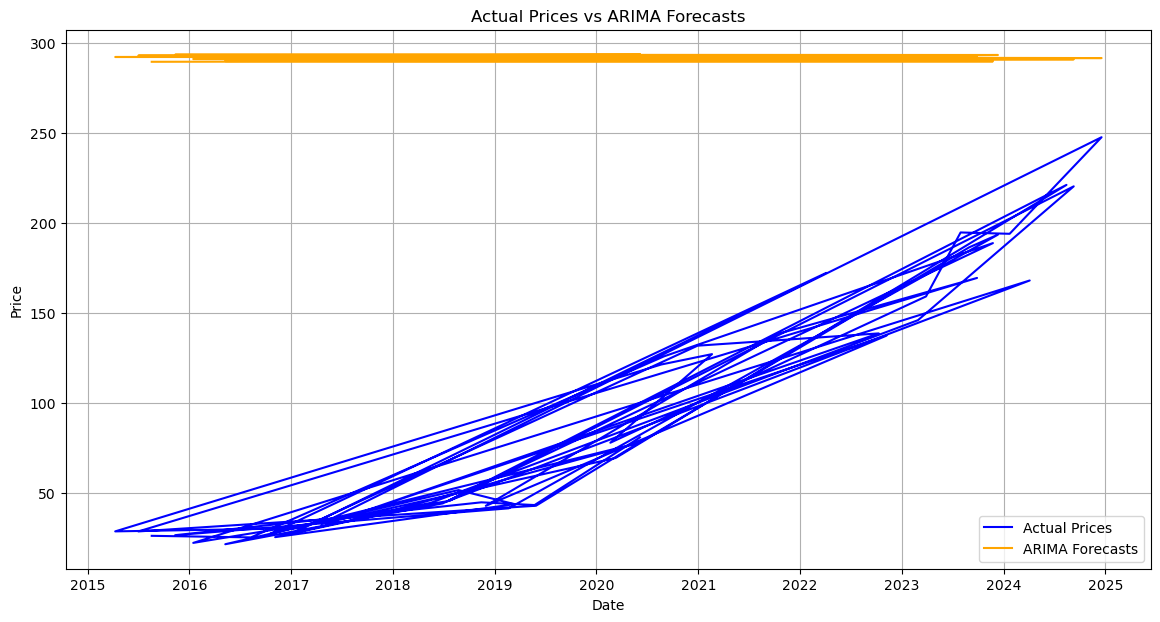

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-50:], y_test.values[-50:], label='Actual Prices', color='blue')
plt.plot(y_test.index[-50:], arima_forecast_test[-50:], label='ARIMA Forecasts', color='orange')
plt.title('Actual Prices vs ARIMA Forecasts')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

* #### Plotting Actual vs Gradient Boosting Predictions

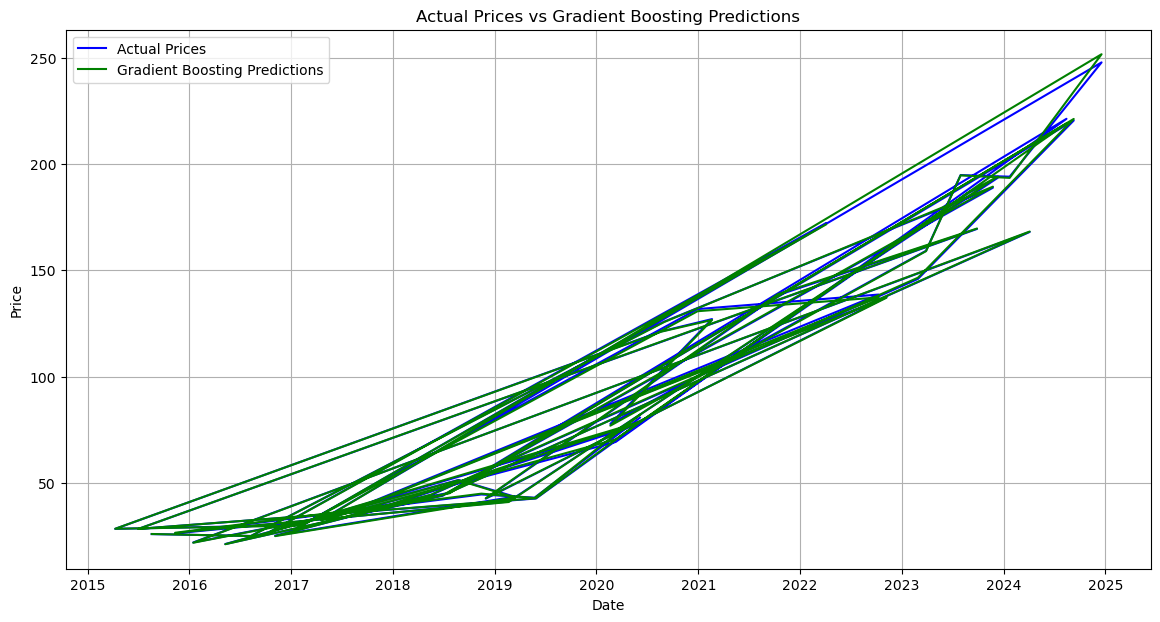

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-50:], y_test.values[-50:], label='Actual Prices', color='blue')
plt.plot(y_test.index[-50:], y_pred_tuned[-50:], label='Gradient Boosting Predictions', color='green')
plt.title('Actual Prices vs Gradient Boosting Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Step 6: Conclusions and Recommendations
* ARIMA Model: Suitable for time-dependent patterns and short-term trend predictions.

* Gradient Boosting Model: Performs well with engineered features, handling sudden fluctuations effectively.

#### Recommendations:

* Combine both models for hybrid predictions.

* Use ARIMA for stable trends and Gradient Boosting for capturing non-linear relationships.